In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. 데이터 불러오기

In [2]:
df_train = pd.read_csv("cs-training.csv")
df_test = pd.read_csv("cs-test.csv")

## 2. 결측치 제거

In [3]:
df_train.dropna(subset=['NumberOfDependents'], inplace=True)   # 가구원 수에 결측치가 있는 샘플 데이터 제거

In [4]:
df_train.shape

(146076, 12)

## 3. 새로운 변수 생성

In [5]:
df_append = df_train.append(df_test)   # 전처리 같이 해주기 위해서 붙여주고 나중에 분리해줄 예정.

In [6]:
bins= [20,60,80,120]
labels_age = ['Adult','Young Senior','Senior']
df_append['AgeGroup'] = pd.cut(df_append['age'], bins=bins, labels=labels_age, right=False)   # 구간별로 구분해주고 이름도 붙여줌.
mask_2 = {
         'Adult':0,
         'Young Senior':1,
         'Senior':2}
df_append['AgeGroup'].replace(mask_2,inplace=True)

pd.cut method는 특정 구간 별로 구분해 카테고리화를 하고 싶을 때 사용한다. 20살에서 60살은 'Adult'. 60살에서 80은 'Yong Senior'. 80에서 120은 'Senior'로 했다.   
단순 boolean 조건절은 np.where로도 가능하다.

In [7]:
df_append['AgeGroup'].value_counts() 

0.0    168451
1.0     69838
2.0      9289
Name: AgeGroup, dtype: int64

## 4. 결측치 보정

In [8]:
df_append['MonthlyIncome'].fillna(df_append['MonthlyIncome'].median(),inplace=True)
df_append['NumberOfDependents'].fillna(df_append['NumberOfDependents'].median(),inplace=True)

In [9]:
df_train = df_append[0:146076]
df_test = df_append[146076:]

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

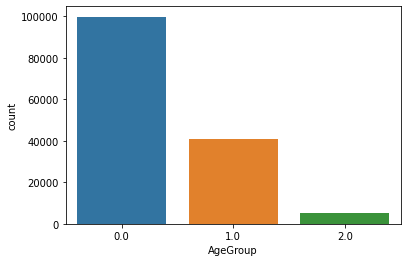

In [10]:
sns.countplot(x="AgeGroup", data=df_train)

In [11]:
df_train['AgeGroup'].fillna(df_train['AgeGroup'].median(),inplace=True)

# 여기까지 전처리 끝

In [13]:
from sklearn.metrics import auc,roc_curve
def plot_roc(pred):
    fpr,tpr,_ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    sns.lineplot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

__이해가 안 되는 걸 가져오기 싫었지만 앞으로 유용할 것 같아서 가져옴.__

## 5. 머신러닝 분석

#### GridCV를 활용한 최적의 파라메터를 탐색하기 위해 Train 데이터 내에서 Train 데이터와 Test 데이터로 나눠준다

In [12]:
train_df = df_train.drop(['Unnamed: 0','SeriousDlqin2yrs'],axis=1)
SeriousDlqIn2Yrs = df_train['SeriousDlqin2yrs']
test_df = df_test.drop(['Unnamed: 0','SeriousDlqin2yrs'],axis=1)

In [13]:
from sklearn.model_selection import train_test_split
y_df = SeriousDlqIn2Yrs
X_df = train_df
X_train,X_test,y_train,y_test = train_test_split(X_df,y_df,test_size=0.2,random_state=0)

#### 첫번째 분류모델. 의사결정나무
##### 데이터 균일도를 바탕으로 규칙기반으로 분류해나가는 방법

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
dt_clf=DecisionTreeClassifier(random_state=0)

In [26]:
params2={'max_depth':[1,2,3,5,7,10],
       'min_samples_split':[5,10,20]}
grid_cv2=GridSearchCV(dt_clf,param_grid=params2,scoring='roc_auc',cv=5)
grid_cv2.fit(X_train,y_train)
print('GridSearchCV 최고 평균 roc_auc 점수:',grid_cv2.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv2.best_params_)

GridSearchCV 최고 평균 roc_auc 점수: 0.8452448635741601
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 7, 'min_samples_split': 20}


In [27]:
best_df_clf=grid_cv2.best_estimator_
pred_df=best_df_clf.predict(X_test)
roc_auc=roc_auc_score(pred_df,y_test)
print('결정트리 예측 roc_auc:',roc_auc)

결정트리 예측 roc_auc: 0.739467845909129


In [30]:
pred_probs=pd.DataFrame(best_df_clf.predict_proba(test_df))[1]
pred_probs.index += 1 
pred_probs.to_csv(r"submit_dctree_data2.csv", index=True)

#### 두번째 분류모델. 랜덤포레스트
##### 랜덤포레스트는 배깅의 한종류로, 같은 알고리즘(의사결정나무)로 여러 개의 분류기를 만들어서 투표를 통해 최종 결정하는 알고리즘. 분류기들에 가중치를 주어 선형결합을 통해 최종 결과를 예측하는 방법에 해당. 쉽게 말해, 기본적인 의사결정나무와는 달리 부트스트랩 방식을 통해 전체데이터에서 중복을 허용하여 n개의 데이터를 추출하고, 또한 피처값 중에서 중복 허용 없이 k개를 추출하여 만든 데이터를 바탕으로 분류기에 넣어 데이터를 예측한다. 이러한 과정을 여러 번 반복하여 여러 개의 분류기에서 나온 결과값을 바탕으로 예측을 진행한다.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [31]:
params={
    'max_depth':[1,3,5,10],
    'min_samples_leaf':[1,3,5,10],
    'min_samples_split':[1,3,5,10]
    }
#RandomForest를 설정하고 GridSearchCV수행
rf_clf=RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params,cv=3,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(X_train,y_train)
cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

최적 하이퍼 파라미터와 예측 roc_auc 점수: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3} 0.8621199369865301


In [40]:
rf_clf=RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=3)
rf_clf.fit(X_train, y_train)
rf_clf_pred = rf_clf.predict(X_test)
roc_auc = roc_auc_score(rf_clf_pred,y_test)
print('랜덤포레스트 예측 roc_auc:',roc_auc)

랜덤포레스트 예측 roc_auc: 0.7741243224771318


In [41]:
#제출 데이터 생성
rf_clf=RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=3)
rf_clf.fit(X_train, y_train)
pred_probs=pd.DataFrame(rf_clf.predict_proba(test_df))[1]
rf_wrapper_pred=pd.DataFrame(pred_probs)
rf_wrapper_pred.index += 1 
rf_wrapper_pred.to_csv(r"submit_rf_data2.csv", index=True)

In [16]:
rf_clf=RandomForestClassifier(max_depth=13, min_samples_leaf=10, min_samples_split=3)
rf_clf.fit(X_df, y_df)
pred_probs=pd.DataFrame(rf_clf.predict_proba(test_df))[1]
rf_wrapper_pred=pd.DataFrame(pred_probs)
rf_wrapper_pred.index += 1 
rf_wrapper_pred.to_csv(r"submit_rf_data2-15.csv", index=True)

#### 세번째 분류모델. XG부스트(회귀도 가능)
##### 부스팅 알고리즘은 분포에 대해 약한 학습자를 반복적으로 학습시켜 최종적으로 강한 학습자를 만드는 것을 목표로한다. 강한 학습자를 만들기 위해 약한 학습자들의 잔차가 큰 잘못 예측한 데이터에 대해 가중치를 부여하여 예측성을 향상시키고자 한다. 의사결정나무를 기반으로 분석하는 부스팅 기법에는 LightGBM과 XGboost가 있으며, 타 부스팅 기법 대시 분석 소요 시간을 획기적으로 줄이면서도, 예측력은 그대로 유지하고 있거나 더 뛰어나다.

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier

y_org = y_train
X_org = X_train

params={
    'max_depth':[1,3,5,10],
    'learning_rate':[1,3,5,10],
    'n_estimators':[1,3,5,10],
    'random_state':[1,3,5,10]
    }

xgb_wrapper = XGBClassifier()
grid_cv = GridSearchCV(xgb_wrapper, param_grid=params,cv=5,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(X_train,y_train)

cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

최적 하이퍼 파라미터와 예측 roc_auc 점수: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 10, 'random_state': 1} 0.8571084907620922


In [36]:
y_org = y_train
X_org = X_train

xgb_wrapper = XGBClassifier(learning_rate=1 , max_depth=3, n_estimators=10, random_state=1)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_org, y_org, early_stopping_rounds=100, eval_metric="logloss",eval_set=evals,verbose=True)
xgb_wrapper_pred = xgb_wrapper.predict(X_test)
print('XGBoost 예측 roc_auc:',roc_auc)

[0]	validation_0-logloss:0.24824
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.19544
[2]	validation_0-logloss:0.18358
[3]	validation_0-logloss:0.18131
[4]	validation_0-logloss:0.17997
[5]	validation_0-logloss:0.17956
[6]	validation_0-logloss:0.17947
[7]	validation_0-logloss:0.17944
[8]	validation_0-logloss:0.17915
[9]	validation_0-logloss:0.17915
XGBoost 예측 roc_auc: 0.739467845909129


In [37]:
#제출 데이터 생성
pred_probs=pd.DataFrame(xgb_wrapper.predict_proba(test_df))[1]
xgb_wrapper_pred=pd.DataFrame(pred_probs)
xgb_wrapper_pred.index += 1 
xgb_wrapper_pred
xgb_wrapper_pred.to_csv(r"submit_xgboost_data2.csv", index=True)

#### 네번쨰 분류모델. LightGBM
##### XG부스트의 개선 분류모델. XG부스트는 부스팅 모델중에서 상대적으로 빠르긴하나, 여전히 시간이 오래 걸린다는 문제점을 가지고 있습니다. 예측성을 유지하면서도 이러한 문제를 해결한 알고리즘이 LightGBM이다. LightGBM은 대용량 데이터 처리에 적합하며, 메모리 사용량도 적으며, CPU뿐만 아니라 GPU도 활용가능하다. 다만, 너무 적은 양의 데이터에 사용시 과적합 문제가 발생할 가능성이 높다

In [34]:
from lightgbm import LGBMClassifier

In [ ]:
params={
    'max_depth':[1,3,5,10],
    'learning_rate':[0.5,1,3,5,10],
    'n_estimators':[1,3,5,10],
    'random_state':[1,3,5,10]
    }

LGBM_wrapper = LGBMClassifier()
grid_cv = GridSearchCV(LGBM_wrapper, param_grid=params,cv=5,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(X_train,y_train)

cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

In [38]:
lgbm_wrapper_time=LGBMClassifier(learning_rate=0.5, max_depth=3, n_estimators=10, random_state=1)
evals=[(X_test,y_test)]
lgbm_wrapper_time.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",eval_set=evals,verbose=True)
lgbm_wrapper_time_preds=lgbm_wrapper_time.predict(X_test)
lgbm_time_roc_auc = roc_auc_score(lgbm_wrapper_time_preds,y_test )
print('LightGBM 최적 파라미터 roc_auc 예측 점수:',lgbm_time_roc_auc)

[1]	valid_0's binary_logloss: 0.200247
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.191184
[3]	valid_0's binary_logloss: 0.185821
[4]	valid_0's binary_logloss: 0.183254
[5]	valid_0's binary_logloss: 0.181818
[6]	valid_0's binary_logloss: 0.180903
[7]	valid_0's binary_logloss: 0.180281
[8]	valid_0's binary_logloss: 0.179871
[9]	valid_0's binary_logloss: 0.179186
[10]	valid_0's binary_logloss: 0.178759
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.178759
LightGBM 최적 파라미터 roc_auc 예측 점수: 0.7510864646723432


In [39]:
pred_probs=pd.DataFrame(lgbm_wrapper_time.predict_proba(test_df))[1]
lgbm_wrapper_pred=pd.DataFrame(pred_probs)
lgbm_wrapper_pred.index += 1 
lgbm_wrapper_pred
lgbm_wrapper_pred.to_csv(r"submit_lgbm_data2.csv", index=True)